# **Brain Tumor Image Classifier**

## **Context**

In this notebook, we will build an image classifier that can distinguish Pituitary Tumor from "No Tumor" MRI Scan images. 

The dataset used in this notebook is available for download from [Kaggle](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri). 

Although this dataset actually has a total of 3,264 images belonging to 4 classes - Glioma Tumor, Meningioma Tumor, Pituitary Tumor and No Tumor, for this project we have only taken two classes, and **we are building a binary classification model to classify between the Pituitary Tumor category vs No Tumor.**

For this project, we will only use 1000 of these images (830 training images and 170 Testing images). For the training dataset, we will take 395 MRI scans of No Tumor and 435 MRI scans of Pituitary Tumor. In our problem, we will also be using Data Augmentation to prevent overfitting, and to make our model model more generalised and robust.

We will use this to build an image classification model for this problem statement, and then show how we can improve our performance by simply "importing" a popular pre-trained model architecture and leveraging the idea of **Transfer Learning**.

## **Objectives**
The objectives of this project are to: 
1. Load and understand the dataset
2. Automatically label the images
3. Perform Data Augmentation
4. Build a classification model for this problem using CNNs
5. Improve the model's performance through Transfer Learning



## **Importing Libraries**

In [1]:
# Library for creating data paths
import os

# Library for randomly selecting data points
import random

# Library for performing numerical computations
import numpy as np

# Library for creating and showing plots
import matplotlib.pyplot as plt

# Library for reading and showing images
import matplotlib.image as mpimg

# Importing all the required sub-modules from Keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

2024-03-15 16:44:50.272971: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 16:44:50.307827: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 16:44:50.307857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 16:44:50.308931: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-15 16:44:50.314134: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 16:44:50.314492: I tensorflow/core/platform/cpu_feature_guard.cc:1

Mounting the drive to load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We have stored the images in a structured folder, and below we create the data paths to load images from those folders. This is required so that we can extract images in an auto-labelled fashion using Keras **flow_from_directory**.

In [3]:
!unzip "/home/cvenigalla/Documents/aiml/AI_ML/Computer Vision/Transfer Learning/brain_tumor-1.zip"

Archive:  /home/cvenigalla/Documents/aiml/AI_ML/Computer Vision/Transfer Learning/brain_tumor-1.zip
  inflating: brain_tumor/.DS_Store   
  inflating: brain_tumor/Training/.DS_Store  
  inflating: brain_tumor/Testing/.DS_Store  
  inflating: brain_tumor/Training/no_tumor/image(87).jpg  
  inflating: brain_tumor/Training/no_tumor/image (52).jpg  
  inflating: brain_tumor/Training/no_tumor/image(157).jpg  
  inflating: brain_tumor/Training/no_tumor/image(243).jpg  
  inflating: brain_tumor/Training/no_tumor/image(230).jpg  
  inflating: brain_tumor/Training/no_tumor/image(218).jpg  
  inflating: brain_tumor/Training/no_tumor/image(264).jpg  
  inflating: brain_tumor/Training/no_tumor/image(7).jpg  
  inflating: brain_tumor/Training/no_tumor/image (20).jpg  
  inflating: brain_tumor/Training/no_tumor/image(100).jpg  
  inflating: brain_tumor/Training/no_tumor/image(198).jpg  
  inflating: brain_tumor/Testing/pituitary_tumor/image(31).jpg  
  inflating: brain_tumor/Testing/pituitary_tumor/

In [4]:
# Parent directory where images are stored in drive
parent_dir = 'brain_tumor'

# Path to the training and testing datasets within the parent directory
train_dir = os.path.join(parent_dir, 'Training')
validation_dir = os.path.join(parent_dir, 'Testing')

# Directory with our training pictures
train_pituitary_dir = os.path.join(train_dir, 'pituitary_tumor')
train_no_dir = os.path.join(train_dir, 'no_tumor')

# Directory with our testing pictures
validation_pituitary_dir = os.path.join(validation_dir, 'pituitary_tumor')
validation_no_dir = os.path.join(validation_dir, 'no_tumor')

## **Visualizing a few images**

Before we move ahead and perform data augmentation, let's randomly check out some of the images and see what they look like:

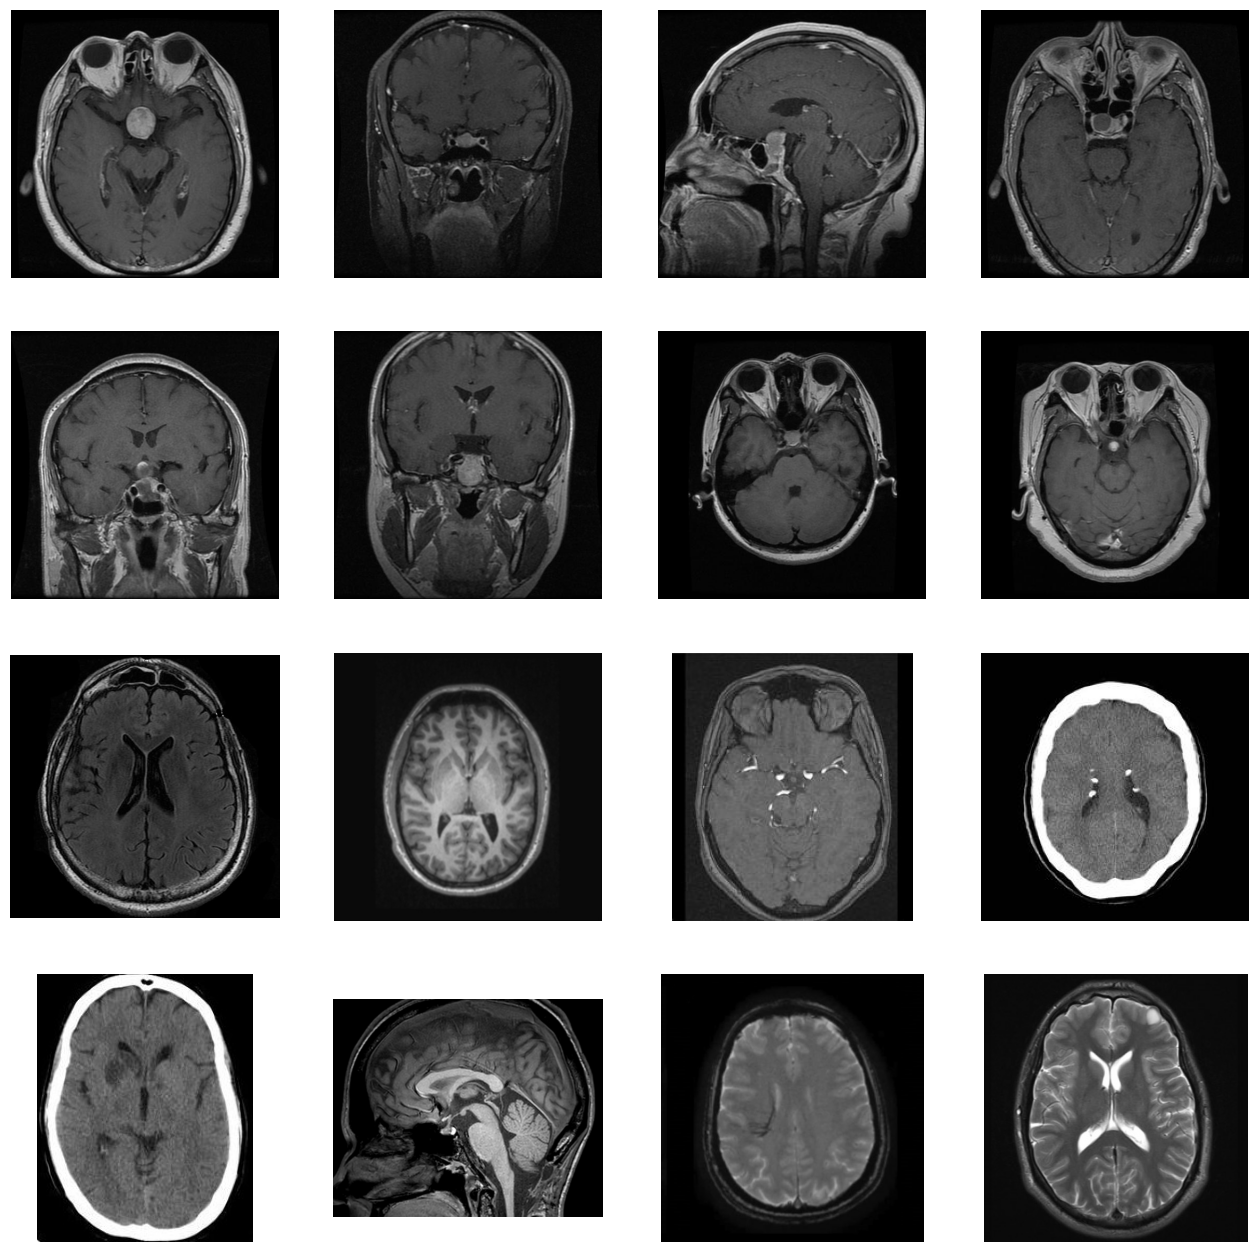

In [5]:
train_pituitary_file_names = os.listdir(train_pituitary_dir)
train_no_file_names = os.listdir(train_no_dir)

fig = plt.figure(figsize=(16, 8))
fig.set_size_inches(16, 16)

pituitary_img_paths = [os.path.join(train_pituitary_dir, file_name) for file_name in train_pituitary_file_names[:8]]
no_img_paths = [os.path.join(train_no_dir, file_name) for file_name in train_no_file_names[:8]]

for i, img_path in enumerate(pituitary_img_paths + no_img_paths):
    ax = plt.subplot(4, 4, i + 1)
    ax.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

As we can see, the images are quite different in size from each other.

This represents a problem, as most CNN architectures, including the pre-built model architectures that we will use for Transfer Learning, **expect all the images to have the same size.** 

So we need to crop these images from the center to make sure they all have the same size. We can do this automatically while performing Data Augmentation, as shown below.

## **Data Augmentation**

In most real-life case studies, it is generally difficult to collect lots of images and then train CNNs. In that case, one idea we can take advantage of is Data Augmentation. CNNs have the property of **translational invariance**, i.e., they can recognize an object as an object, even when its appearance varies translationally in some way. Taking this property into consideration, we can augment the images using the following techniques: 

**1. Horizontal Flip** (should be set to True/False) <br>
**2. Vertical Flip** (should be set to True/False) <br>
**3. Height Shift** (should be between 0 and 1) <br>
**4. Width Shift** (should be between 0 and 1) <br>
**5. Rotation** (should be between 0 and 180) <br>
**6. Shear** (should be between 0 and 1) <br>
**7. Zoom** (should be between 0 and 1) etc. <br>

Remember ***not to use data augmentation in the validation/test data set***.

Also, as mentioned above, we need to have images of the same size. So below,we resize the images by using the parameter **target_size**. Here we are resizing it to **224 x 224**, as we will be using the **VGG16** model for Transfer Learning, which takes image inputs as **224 x 224**. 

As this is a binary classification problem, we will need class labels. This is directly handled by the **flow_from_directory** function. It will take the images from the folder inside our specified directory, and the images from one folder will belong to same class.

As the train directory has 2 folders pituitary_tumor and no_tumor, it will read the directory and each folder will be considered a separate class. We specify **class_model = 'binary'** as this is a binary classification problem.

As the folders inside the directory will be read in an alphabetical order, the no_tumor folder will be given a label 0, and pituitary_tumor will be label 1. 

In [6]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

# Flowing training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(224, 224))     

# Flowing testing images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224))

Found 830 images belonging to 2 classes.
Found 170 images belonging to 2 classes.


Let's look at some examples of our augmented training data. 

This is helpful for understanding the extent to which data is being manipulated prior to training, and can be compared with how the raw data looks prior to data augmentation.

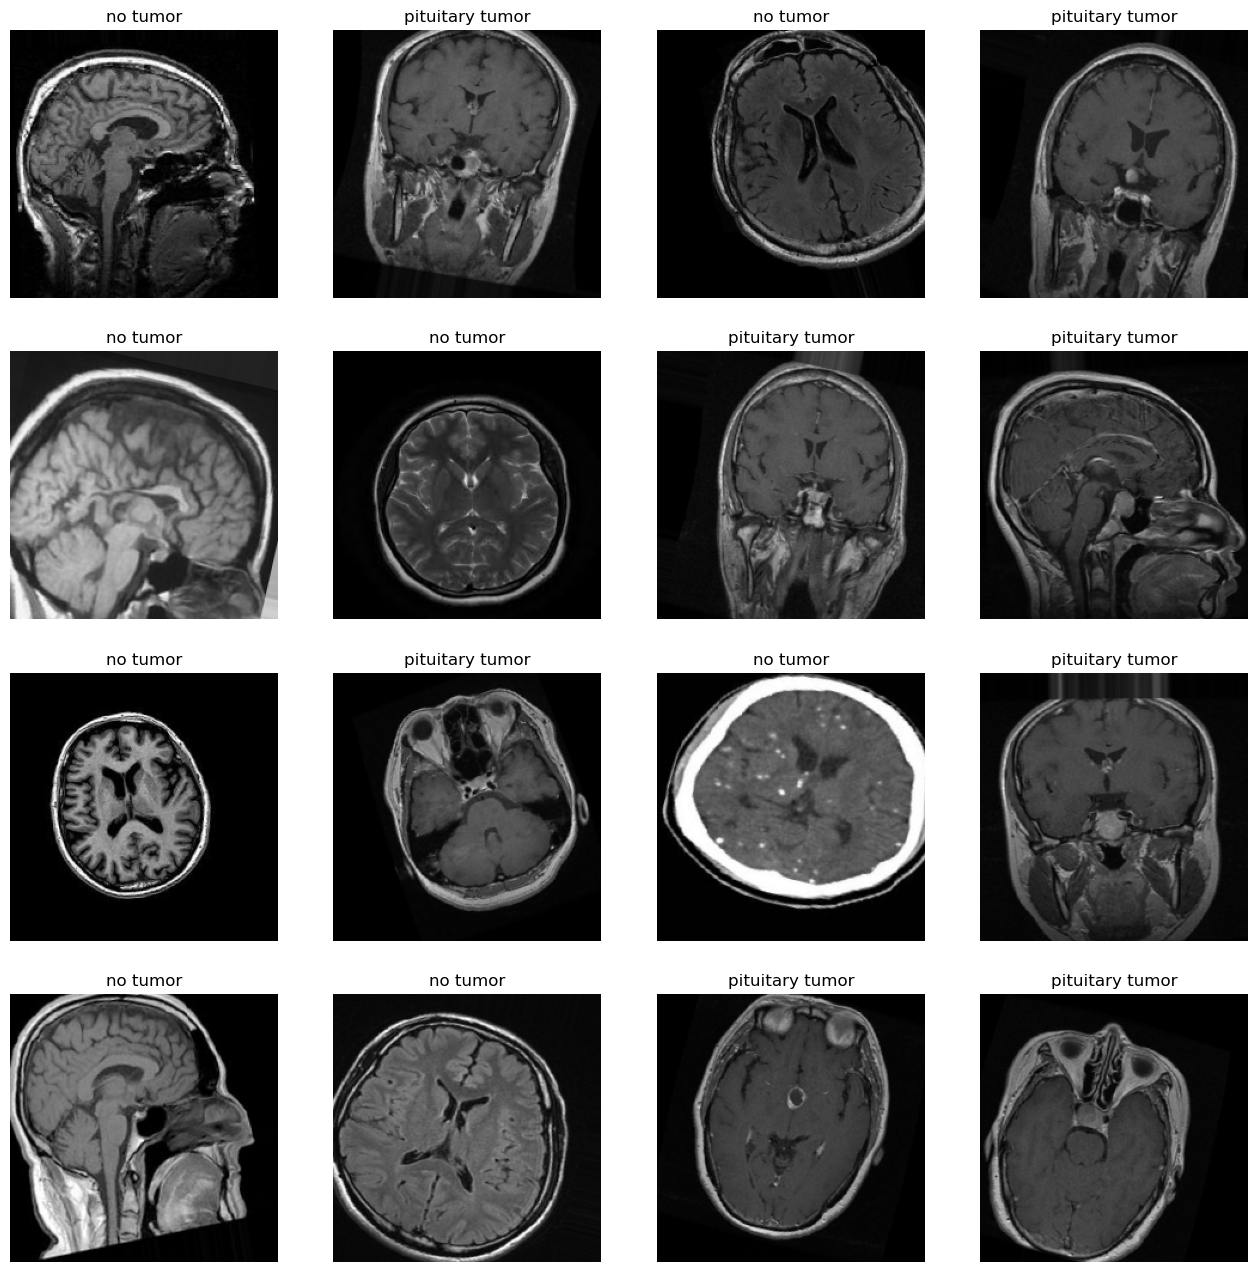

In [7]:
images, labels = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label == 1: 
        ax.set_title('pituitary tumor')
    else:
        ax.set_title('no tumor')
    ax.axis('off')

## **CNN Model Building**

Once the data is augmented and cropped to have the same size, we are now ready to build a first baseline CNN model to classify no_tumor vs pituitary_tumor.

When building our custom model, we have used Batch Normalization and Dropout layers as regularization techniques to prevent overfitting.

In [9]:
cnn_model = Sequential()
cnn_model.add(Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3), padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(16, (3,3), activation='relu', padding = 'same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

In [10]:
cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                        

In [11]:
# Pulling a single large batch of random testing data for testing after each epoch
testX, testY = validation_generator.next()

In [12]:
model_history = cnn_model.fit(train_generator, 
                              validation_data=(testX, testY),
                              epochs=10)

Epoch 1/10


2024-03-15 16:47:18.028783: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 256901120 exceeds 10% of free system memory.
2024-03-15 16:47:18.732750: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 256901120 exceeds 10% of free system memory.


 1/42 [..............................] - ETA: 1:52 - loss: 0.7355 - accuracy: 0.5000

2024-03-15 16:47:19.053823: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 256901120 exceeds 10% of free system memory.
2024-03-15 16:47:19.568427: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 256901120 exceeds 10% of free system memory.


 2/42 [>.............................] - ETA: 31s - loss: 0.8014 - accuracy: 0.5250 

2024-03-15 16:47:19.830125: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 256901120 exceeds 10% of free system memory.


42/42 [==============================] - 40s 898ms/step - loss: 0.4808 - accuracy: 0.7470 - val_loss: 0.5351 - val_accuracy: 0.7000
Epoch 2/10
42/42 [==============================] - 40s 959ms/step - loss: 0.4074 - accuracy: 0.8193 - val_loss: 0.8725 - val_accuracy: 0.4500
Epoch 3/10
42/42 [==============================] - 48s 1s/step - loss: 0.3573 - accuracy: 0.8651 - val_loss: 1.4925 - val_accuracy: 0.4500
Epoch 4/10
42/42 [==============================] - 48s 1s/step - loss: 0.2602 - accuracy: 0.8880 - val_loss: 1.6950 - val_accuracy: 0.4500
Epoch 5/10
42/42 [==============================] - 49s 1s/step - loss: 0.2187 - accuracy: 0.9265 - val_loss: 1.8553 - val_accuracy: 0.4500
Epoch 6/10
42/42 [==============================] - 49s 1s/step - loss: 0.1968 - accuracy: 0.9265 - val_loss: 0.6244 - val_accuracy: 0.7500
Epoch 7/10
42/42 [==============================] - 48s 1s/step - loss: 0.1900 - accuracy: 0.9325 - val_loss: 0.4597 - val_accuracy: 0.8500
Epoch 8/10
42/42 [=======

In [13]:
# Evaluating on the Test dataset
cnn_model.evaluate(validation_generator)

9/9 [==============================] - 2s 214ms/step - loss: 2.1915 - accuracy: 0.6471


[2.1914515495300293, 0.6470588445663452]

### **Findings**

- Our model had 840,369 trainable parameters.
- After running 10 epochs, we were able to achieve a training accuracy of ~95% and a testing accuracy of ~72%.
- Even after using Data Augmentation, Batch Normalization and the Dropout Layers, the model seems to have highly overfit on the training dataset and is performing somewhat poorly.

## **Model Building using Transfer Learning: VGG 16**

- Now, let's try again, but this time, using the idea of **Transfer Learning**. We will be loading a pre-built architecture - **VGG16**, which was trained on the ImageNet dataset and finished runner-up in the ImageNet competition in 2014. Below is a schematic of the VGG16 model.

- For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. We will remove the already-present fully-connected layers and add our own fully-connected layers for this binary classification task.


![vgg16](https://upload.wikimedia.org/wikipedia/commons/2/24/VGG16.png)

In [14]:
# Summary of the whole model
model = VGG16(weights='imagenet')
model.summary()

553467096/553467096 [==============================] - 20s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [15]:
# Getting only the conv layers for transfer learning.
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [16]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

- To remove the fully-connected layers of the imported pre-trained model, while calling it from Keras we can also specify an additonal keyword argument that is **include_top**. 

- **If we specify include_top = False, then the model will be imported without the fully-connected layers.** Here we won't have to do the above steps of getting the last convolutional layer and creating a separate model.

- If we are specifying include_top = False, we will also have to specify our input image shape.

- Keras has this keyword argument as generally while importing a pre-trained CNN model, we don't require the fully-connected layers and we train our own fully-connected layers for our task.

In [17]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (224,224,3))
vgg_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [18]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [19]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [20]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(1, activation='sigmoid'))

In [21]:
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                802848    
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 15518625 (59.20 MB)
Trainable params: 803937 (3.07 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [22]:
## Fitting the VGG model
new_model_history = new_model.fit(train_generator, 
                                  validation_data=(testX, testY),
                                  epochs=5)

Epoch 1/5
42/42 [==============================] - 204s 5s/step - loss: 0.4530 - accuracy: 0.8157 - val_loss: 0.2844 - val_accuracy: 0.9000
Epoch 2/5
42/42 [==============================] - 209s 5s/step - loss: 0.1055 - accuracy: 0.9578 - val_loss: 0.2009 - val_accuracy: 0.8500
Epoch 3/5
42/42 [==============================] - 209s 5s/step - loss: 0.1037 - accuracy: 0.9663 - val_loss: 0.1920 - val_accuracy: 0.9000
Epoch 4/5
42/42 [==============================] - 211s 5s/step - loss: 0.0507 - accuracy: 0.9819 - val_loss: 0.1269 - val_accuracy: 0.9500
Epoch 5/5
42/42 [==============================] - 213s 5s/step - loss: 0.0489 - accuracy: 0.9855 - val_loss: 0.1298 - val_accuracy: 0.9000


In [23]:
# Evaluating on the Test set
new_model.evaluate(validation_generator)

9/9 [==============================] - 34s 4s/step - loss: 0.2234 - accuracy: 0.9059


[0.22343577444553375, 0.9058823585510254]

In [24]:
# Function to plot loss, val_loss, 
def plot_history(history):
    N = len(history.history["accuracy"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training accuracy Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("accuracy")
    plt.legend(loc="upper right")

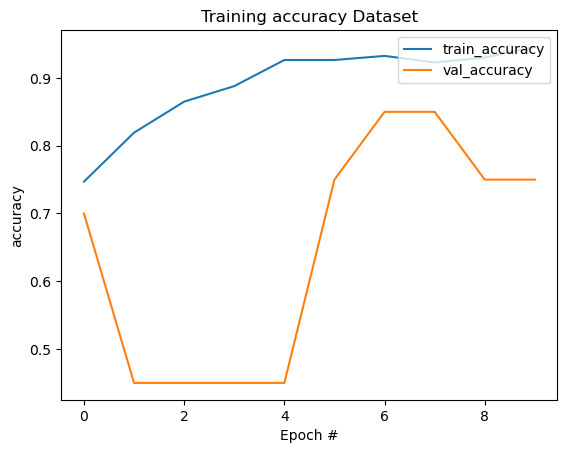

In [25]:
# Plotting the loss vs epoch curve for the basic CNN model without Transfer Learning
plot_history(model_history)

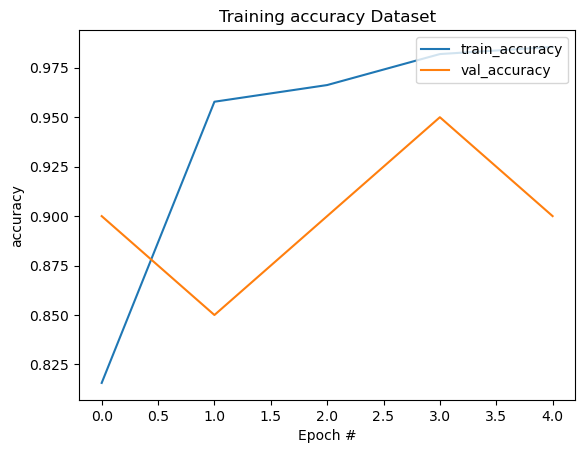

In [26]:
# Plotting the loss vs epoch curve for the Transfer Learning model
plot_history(new_model_history)

### Findings

- Our model has 803,937 Trainable parameters.
- After running 5 epochs we were able to achieve a training accuracy of ~98% and a validation accuracy of ~ 91%.

## **Conclusions**

- The difference in both models is evident. Both models had nearly the same number of trainable parameters. However even after training the custom CNN model for 10 epochs, it could not attain accuracies as high as we achieved with Transfer Learning.

- The Transfer Learning model has converged faster than the custom CNN model in only 5 epochs.

- That's a good level of improvement just by directly using a pre-trained architecture such as VGG16.

- This model can, in fact, further be tuned to achieve the accuracies required for practical applicability in the medical domain.